In [1]:
import json
import ast
import pandas as pd
import csv
import requests
import time
import traceback
from sqlalchemy import *
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import datetime
import instaconfig
from pytz import timezone

from geopy.distance import vincenty

from sklearn.neighbors.kde import KernelDensity
from sklearn.grid_search import GridSearchCV

instagram, database, search_tags = instaconfig.config()

engine = create_engine('mysql://%(user)s:%(pass)s@%(host)s' % database)
engine.execute('use instagram')

q = '''
    SELECT *
    FROM posts
    WHERE searched_tag IN 
    %s ;
    ''' % ("('" + "','".join(search_tags[:6]) + "')")  # :7

#print q

df = pd.read_sql_query(q,con = engine)

%matplotlib inline
%pylab inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['insert', 'text', 'over', 'cast', 'Text', 'table', 'extract', 'select', 'delete']
`%matplotlib` prevents importing * from pylab and numpy


In [2]:
filter_coord = {
    'ul_lat' : 37.85,
    'ul_long' : -122.35,
    'lr_lat' : 37.7,
    'lr_long' : -122.6
    }

sf_df = df[(df.lat <= filter_coord['ul_lat']) & (df.longitude <= filter_coord['ul_long']) & (df.lat >= filter_coord['lr_lat']) & (df.longitude >= filter_coord['lr_long'])]

sf_df = sf_df.reset_index()

In [2]:
sf_df = df

Xtrain = np.vstack((sf_df.longitude, sf_df.lat)).T
Xtrain *= np.pi/180

In [3]:
##############################################################################
# Compute DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=4e-5, 
            min_samples=5,
            metric='haversine'
           ).fit(Xtrain)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = list(db.labels_)

#labels = [int(label) for label in labels]

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

sf_df['cluster_label'] = pd.Series(labels)

Estimated number of clusters: 1144


## Cluster geographic map

In [48]:
# Drops one circle per cluster, does not include spatial outliers

import folium
from IPython.display import IFrame

from geopy.geocoders import Nominatim

map_osm = folium.Map(location=[filter_coord['ul_lat'], filter_coord['ul_long']],
                    tiles='OpenStreetMap')

colors = [
    '#d73027',
    '#f46d43',
    '#fdae61',
    '#fee090',
    '#e0f3f8',
    '#abd9e9',
    '#74add1',
    '#4575b4'
]

labels = [int(label) for label in labels if label != -1]

color_labels = [colors[label % 7] for label in labels]

def make_circle(lat,lon,image_url,color_label): 
    map_osm.circle_marker(
        location = [lat,lon],
        radius=100,
        line_color=color_label,
        fill_color=color_label,
        popup = '<img src={url} width=200 height=200><br>'.format(
            url=image_url)
    )

map_osm.simple_marker(
    location = [filter_coord['ul_lat']-.055, filter_coord['ul_long']-.085]
)

sf_df_remove_outliers = sf_df[sf_df['cluster_label'] != -1]

pics = sf_df_remove_outliers[['lat','longitude','stand_res_url']].values
    
make_circle_vec = np.vectorize(make_circle)

make_circle_vec(pics[:,0],pics[:,1],pics[:,2],color_labels)

map_osm.create_map(path='osm.html')

IFrame('osm.html', 700, 700)

## Temporal Binning

In [4]:
df1 = sf_df[['created_time','cluster_label']]
df1['day_of_week'] = sf_df['created_time'].apply(lambda x: int(datetime.datetime.fromtimestamp(x).weekday()))
df1['day_of_month'] = sf_df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).day)
df1['hour_of_day'] = sf_df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).hour)
df1['month'] = sf_df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).month)
df1['year'] = sf_df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).year)

# Bin by some number of hours
time_bin_hours = 4
df1['hour_of_day'] = df1['hour_of_day'].apply(lambda x : x / time_bin_hours)

arrival_times = df1.groupby(['year','month','day_of_month','hour_of_day','day_of_week','cluster_label']).count().reset_index()
#(df1.groupby(['day_of_week','hour_of_day'])['created_time'].count()/249).plot()


#print arrival_times

/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [6]:
import seaborn as sns

#sns.tsplot(data = df1)
df2 = df1[['day_of_week','day_of_month','hour_of_day','month','year','created_time']]
df2 = df2.groupby(['day_of_week','day_of_month','hour_of_day','month','year']).count()
df2['created_time'] = df2.apply(lambda x: 1 if (x['created_time'] > 0) else 0, axis = 1)

df2 = df2.reset_index()

pd.pivot_table(df2,values = 'created_time', index = ['year','month','day_of_month'], columns = ['day_of_week','hour_of_day'])



day_of_week               0                       1             ...   5      \
hour_of_day               0   1   2   3   4   5   0   1   2   3 ...   2   3   
year month day_of_month                                         ...           
2011 2     8            NaN NaN NaN NaN NaN NaN NaN NaN   1 NaN ... NaN NaN   
           23           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
     4     24           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
     7     9            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
     9     16           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
     10    29           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
2012 1     3            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           11           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           29           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
     2     8            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           11           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN   1   
           15           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
     3     7            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
     4     15           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           20           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
     5     30           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
     6     3            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           7            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           13           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           18           NaN NaN NaN NaN   1 NaN NaN NaN NaN NaN ... NaN NaN   
           21           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           24           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
     7     10           NaN NaN NaN NaN NaN NaN   1 NaN NaN NaN ... NaN NaN   
           11           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           16           NaN NaN NaN NaN   1 NaN NaN NaN NaN NaN ... NaN NaN   
           18           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           27           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           30           NaN NaN NaN NaN NaN   1 NaN NaN NaN NaN ... NaN NaN   
           31           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
     8     6            NaN NaN NaN   1 NaN NaN NaN NaN NaN NaN ... NaN NaN   
...                      ..  ..  ..  ..  ..  ..  ..  ..  ..  .. ...  ..  ..   
2015 8     16           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           19           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           21           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           22           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...   1   1   
           23           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           24           NaN NaN   1 NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           25           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           27           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           28           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           29           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN   1   
           30           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           31           NaN   1 NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
     9     1            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           3            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           4            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN   
           5            NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN   1   
           6            NaN NaN NaN NaN NaN NaN Na

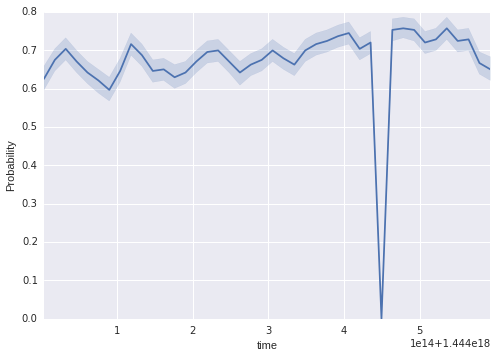

In [6]:
timestamps = pd.DataFrame(df1['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x)))

timestamps['weeks_back'] = timestamps.apply(lambda x: datetime.datetime.now()- x)
timestamps['weeks_back'] = timestamps['weeks_back'].apply(lambda x: x.astype('timedelta64[W]')/ np.timedelta64(1,'W'))
timestamps['day_of_week'] = timestamps['created_time'].apply(lambda x: x.weekday())
timestamps['hour_of_day'] = timestamps['created_time'].apply(lambda x: x.hour / 4 )#time_bin_hours)
timestamps['count'] = 1

occupancy = timestamps.groupby(['weeks_back','day_of_week','hour_of_day']).count().reset_index()
occupancy['count'] = occupancy['count'].apply(lambda x: 1 if x > 0 else 0)

ts_binned = pd.pivot_table(occupancy[['weeks_back','day_of_week','hour_of_day','count']], values = 'count', columns = ['day_of_week','hour_of_day'], index ='weeks_back')
ts_binned = ts_binned.applymap(lambda x: 0 if np.isnan(x) else x)

time_bins = []
for day in xrange(0,7):
    for hour_bin in xrange(0,6):
        #time_bins.append(pd.to_datetime('%d-%d-%d-%d' % (2015, 10, 5+day,4*hour_bin)))
        time_bins.append(datetime.datetime(year = 2015, month = 10, day = 5 + day, hour = 4*hour_bin))
 

#print time_bins

import seaborn as sns

#print ts_binned.reset_index().columns
ts_binned[5,1] = 0

time_bins = pd.Series(time_bins)
#time_bins = time_bins.apply(lambda x: x.weekday)
#time_bins.columns = 'days'


sns.tsplot(data = ts_binned.values,
           time = time_bins.values)
sns.axlabel('time', 'Probability')

In [27]:
ts_binned.values

array([[ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [ ]:
np.timedelta64.

([<matplotlib.axis.YTick at 0x7f18a61c8b50>,
 <a list of 5 Text yticklabel objects>)

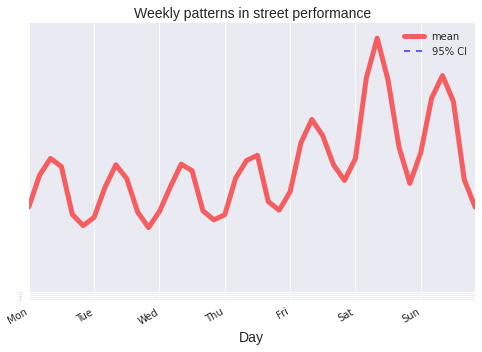

In [7]:
import matplotlib.dates as mdates
# Compute occupancy probability over all San Francisco
from scipy.stats import beta

occupancy = (arrival_times.reset_index().groupby(['day_of_week','hour_of_day']).count()['year']).reset_index()

day_bins = np.zeros([7,24/time_bin_hours])

#for ii in xrange(0,7):
#    day_bins[ii] = np.zeros(24)

for ii in occupancy.index:
     day_bins[int(occupancy.loc[ii]['day_of_week'])][int(occupancy.loc[ii]['hour_of_day'])] = occupancy.loc[ii]['year']

l, u, md = zeros(7*24/time_bin_hours), zeros(7*24/time_bin_hours), zeros(7*24/time_bin_hours)

day_bins = day_bins.reshape([7*24/time_bin_hours])

for ii in xrange(0,7*24/time_bin_hours):
    
    a, b = day_bins[ii], 243-day_bins[ii]  #243
    
    alpha = .05

    l[ii] = beta.ppf(alpha / 2, a=a, b=b)
    u[ii] = beta.ppf(1 - alpha / 2, a=a, b=b)
    md[ii] = np.divide(a - 1, a + b - 2)

#mondays = mdates.WeekdayLocator(mdates.MONDAY)        # major ticks on the mondays
alldays = mdates.DayLocator()              # minor ticks on the days
hourFormatter = mdates.DateFormatter('%a')  # e.g., Jan 12
dayFormatter = mdates.DateFormatter('%A')      # e.g., 12    

fig, ax = plt.subplots(1,1)
fig.autofmt_xdate()
mn = ax.plot(time_bins.values, md, 'r-', lw=5, alpha=0.6, label = 'mean')
cil = ax.plot(time_bins.values, l, 'b--', lw=2, alpha=0.6, label = '95% CI')
ciu = ax.plot(time_bins.values, u, 'b--', lw=2, alpha=0.6,)
ax.legend()
ax.fmt_xdata = mdates.DateFormatter('%A')

#ax.xaxis.set_major_locator(alldays)
ax.xaxis.set_major_locator(alldays)
ax.xaxis.set_major_formatter(hourFormatter)
#ax.xaxis.set_minor_locator(mondays)

#ax.fill_between(range(0,7*24/4),md,l,facecolor = 'b')
#ax.fill_between(range(0,7*24/4),u,md,facecolor = 'b')
plt.title("Weekly patterns in street performance", fontsize = 14)
plt.xlabel("Day", fontsize = 14)
#plt.xticks(range(0,45,5), fontsize=14)
plt.yticks([0,.05,.1,.15,.2], fontsize=0)


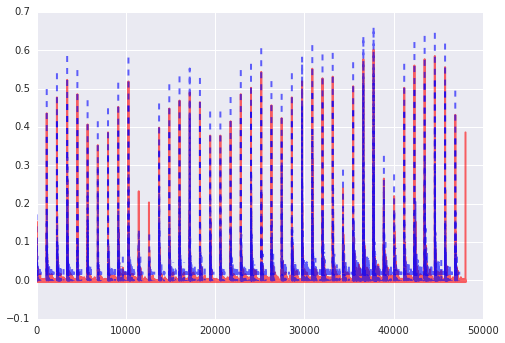

In [8]:
# Compute occupancy probability PER CLUSTER
from scipy.stats import beta

bins_in_day = 24/time_bin_hours
bins_in_week = 7*bins_in_day

occupancy = (arrival_times.reset_index().groupby(['day_of_week','hour_of_day','cluster_label']).count()['year']).reset_index()
day_bins = np.zeros([7,bins_in_day,n_clusters_])

# unpack occupancy
for ii in occupancy.index:
     day_bins[int(occupancy.loc[ii]['day_of_week'])][int(occupancy.loc[ii]['hour_of_day'])][int(occupancy.loc[ii]['cluster_label'])] = occupancy.loc[ii]['year']

l, u, md = zeros(bins_in_week*n_clusters_), zeros(bins_in_week*n_clusters_), zeros(bins_in_week*n_clusters_)
day_bins = day_bins.reshape([bins_in_week*n_clusters_])

# average
md = np.divide(day_bins, 243)

# MAP estimates per bin
for ii in xrange(0,bins_in_week*n_clusters_):
    a, b = day_bins[ii], 243-day_bins[ii]             # Default = 243
    alpha = .05                                       # leftover probability
    l[ii] = beta.ppf(alpha / 2.0, a=a, b=b)           # lower threshhold
    u[ii] = beta.ppf(1.0 - alpha / 2.0, a=a, b=b)     # upper threshhold
    md[ii] = np.divide(a - 1.0, a + b - 2.0)          # mode

fig, ax = plt.subplots(1,1)
ax.plot(range(0,bins_in_week*n_clusters_), md, 'r-', lw=2, alpha=0.6)
ax.plot(range(0,bins_in_week*n_clusters_), l, 'b--', lw=2, alpha=0.6)
ax.plot(range(0,bins_in_week*n_clusters_), u, 'b--', lw=2, alpha=0.6)

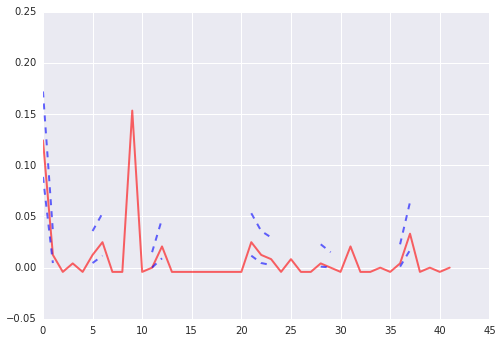

In [9]:
fig, ax = plt.subplots(1,1)
ax.plot(range(0,bins_in_week), md[:bins_in_week], 'r-', lw=2, alpha=0.6)
ax.plot(range(0,bins_in_week), l[:bins_in_week], 'b--', lw=2, alpha=0.6)
ax.plot(range(0,bins_in_week), u[:bins_in_week], 'b--', lw=2, alpha=0.6)

## MAP Estimate and Credible Intervals

/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


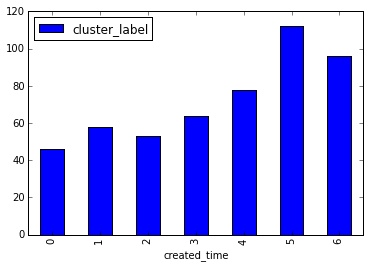

In [93]:
# Pictures binned by day of the week

df1 = sf_df[['created_time','cluster_label']]
df1['created_time'] = sf_df['created_time'].apply(lambda x: int(datetime.datetime.fromtimestamp(x).weekday()))
df1.groupby(['created_time']).count().plot(kind = 'bar')

/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


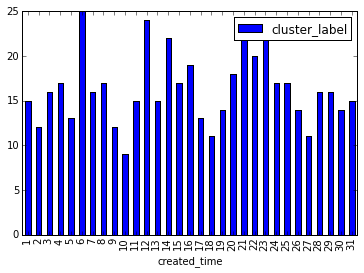

In [84]:
# Pictures binned by day of month
df1['created_time'] = sf_df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).day)
df1.groupby(['created_time']).count().plot(kind = 'bar')

/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


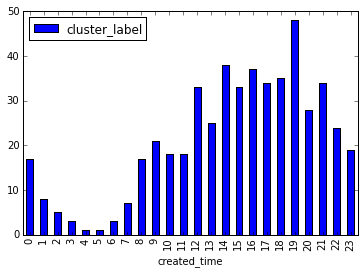

In [86]:
# Pictures binned by hour of day
df1['created_time'] = sf_df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).hour)
df1.groupby(['created_time']).count().plot(kind = 'bar')

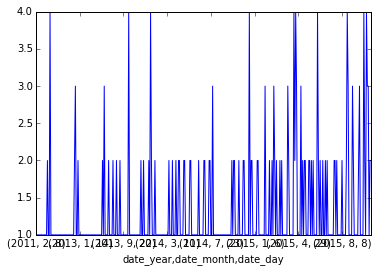

In [90]:
df1 = sf_df.groupby(['date_year','date_month','date_day']).count()['post_id'].plot()

## Compute Cluster Radius

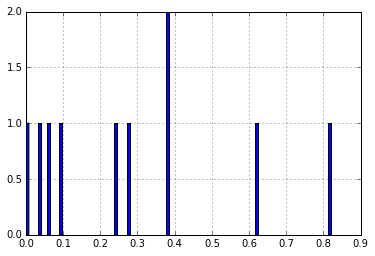

In [43]:
from geopy.distance import vincenty

# Remove entries not belonging to a cluster
cluster_df = sf_df[sf_df['cluster_label'] != -1]

cluster_centroids = cluster_df[['cluster_label','lat','longitude']].groupby(['cluster_label']).mean().reset_index()
cluster_point_centroids = pd.merge(left = cluster_df[['cluster_label','lat','longitude']], right = cluster_centroids, how = 'inner', on = 'cluster_label', suffixes = ('_point','_centroid')).reset_index()

# Distance measure
def dist(x1,x2,y1,y2):
    return vincenty((x1,x2),(y1,y2)).miles
    #return np.sqrt(np.square(x1-y1)+np.square(x2-y2))

# Calculate distance of each point from centroid
cluster_point_centroids['distance_from_centroid'] = cluster_point_centroids.apply(lambda x: dist(x['lat_point'], x['longitude_point'], x['lat_centroid'], x['longitude_centroid']),axis = 1)

# Max over all distances from centroid
cluster_radius = cluster_point_centroids.groupby('cluster_label').max().reset_index()
cluster_radius = cluster_radius[['cluster_label','lat_centroid','longitude_centroid','distance_from_centroid']]



ax = cluster_radius['distance_from_centroid'].hist(bins = 100)

In [13]:
import folium
from IPython.display import IFrame

from geopy.geocoders import Nominatim

map_osm = folium.Map(location=[filter_coord['ul_lat'], filter_coord['ul_long']],
                    tiles='OpenStreetMap')

colors = [
    '#d73027',
    '#f46d43',
    '#fdae61',
    '#fee090',
    '#e0f3f8',
    '#abd9e9',
    '#74add1',
    '#4575b4'
]

#labels = [int(label) for label in labels if label != -1]

color_labels = [colors[label % 7] for label in xrange(0,n_clusters_)]

def make_circle(lat,lon,cluster_label,color_label): 
    map_osm.circle_marker(
        location = [lat,lon],
        radius=100,
        line_color=color_label,
        fill_color=color_label,
        popup = str(cluster_label)
    )


#sf_df_remove_outliers = sf_df[sf_df['cluster_label'] != -1]

#pics = sf_df_remove_outliers[['lat','longitude','stand_res_url']].values
pics = cluster_radius[['lat_centroid','longitude_centroid','cluster_label']].values

make_circle_vec = np.vectorize(make_circle)

make_circle_vec(pics[:,0],pics[:,1],pics[:,2],color_labels)

map_osm.create_map(path='osm.html')

IFrame('osm.html', 700, 700)

## Evaluate post density

0.188158710477


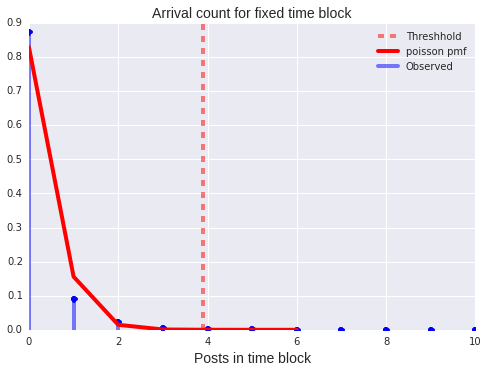

In [22]:
from scipy.stats import poisson

# Bin by cluster and by time period down to x hour blocks
temp_bin = df1.groupby(['cluster_label','day_of_week','day_of_month','hour_of_day','month','year']).count().reset_index()

# Remove outliers and relabel column
temp_bin_no_spatial_outliers = temp_bin[temp_bin['cluster_label'] != -1]
temp_bin_no_spatial_outliers.rename(columns = {'created_time' : 'num_posts_per_time_slot'}, inplace = True)

posts_per_time_period = temp_bin_no_spatial_outliers.groupby(['num_posts_per_time_slot','hour_of_day']).count()['cluster_label'].reset_index()

def plot_arrival_hist(time_bin):
    dist_posts_per_time_period = posts_per_time_period[posts_per_time_period['hour_of_day'] == time_bin]['cluster_label'].reset_index()['cluster_label']
    emp_dist = (dist_posts_per_time_period/dist_posts_per_time_period.sum()).values
    mu = dot(np.array(range(0,len(emp_dist))),emp_dist)
    print mu
    
    fig, ax = plt.subplots()
    ax.plot(range(0,len(emp_dist)), emp_dist, 'bo')
    ax.vlines(range(0,len(emp_dist)), 0, emp_dist, 'b', lw=4, alpha=0.5,label='Observed')
    
    ax.plot([3.9,3.9],[0,.9], 'r--',lw = 4, alpha = 0.5, label = 'Threshhold')
    
    x = np.arange(poisson.ppf(0.01, mu),
                  poisson.ppf(0.999999999, mu))
    ax.plot(x, poisson.pmf(x, mu), 'r-', ms=8, lw = 4, label='poisson pmf')
    plt.yscale('linear')
    #ax.vlines(x, 0, poisson.pmf(x, mu), colors='r', lw=5, alpha=0.5)
    
    #plot(range(1,len(emp_dist)+1),emp_dist, 'b-')

    
#plot_arrival_hist(0)
#plot_arrival_hist(1)
#plot_arrival_hist(2)
#plot_arrival_hist(3)
#plot_arrival_hist(4)
plot_arrival_hist(5)
#num_posts = posts_per_time_period.sum()

plt.xlabel('Posts in time block', fontsize = 14)
plt.ylabel('', fontsize = 14)
plt.title('Arrival count for fixed time block', fontsize = 14)
plt.legend()
#ax.xtick(range(0,1,.1), fontsize = 14))

#(posts_per_time_period/num_posts).plot(kind = 'bar')

#temp_bin_no_spatial_outliers['num_posts_per_time_slot'].mean()

In [214]:
plt.yscale

'log'

In [212]:
import matplotlib.pyplot as plt

In [23]:
from sklearn.svm import OneClassSVM

posts_no_spatial_outliers = sf_df[sf_df['cluster_label'] != -1]

Xtrain_svm = np.vstack((posts_no_spatial_outliers.longitude, posts_no_spatial_outliers.lat)).T
Xtrain_svm *= np.pi/180

OCSVM = OneClassSVM(kernel='rbf', degree=3, gamma=0.0, coef0=0.0, tol=0.001, nu=0.5, shrinking=True, cache_size=200, verbose=False, max_iter=-1, random_state=None)

OCSVM.fit(Xtrain_svm)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.0, kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [132]:
import random

def some(x, n):
    return x.ix[random.sample(x.index, n)]

def check_spatial_membership(point):
    matches = cluster_radius[cluster_radius.apply(lambda x: vincenty(point,(x['lat_centroid'],x['longitude_centroid'])) <= x['distance_from_centroid'], axis = 1)]['cluster_label'].reset_index()
    if len(matches) < 1:
        return -1
    elif len(matches) == 1:
        return int(matches['cluster_label'])
    else:
        print "Something odd may happen"
        return int(matches.ix[random.sample(matches.index,1)]['cluster_label'])

In [136]:
point_check = sf_df[sf_df['cluster_label'] == 5][['lat','longitude']].values

for ii in xrange(0,len(point_check)):
    print check_spatial_membership(point_check[ii].tolist())

#for ii in xrange(0,n_clusters_):
#    print len(sf_df[sf_df['cluster_label'] == ii])

-1
-1
5
5
-1
-1
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
-1
5
5
-1
5
5
5
5
5
5
5
-1
5
-1
-1
5
5
5
5
5
5
5
5
5
-1
5
5
5
-1
5
5
5
-1
5
5
5
-1
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
-1
-1
-1
5
5
-1
5
5
5
-1
5
-1
5
5
5
5
5
5
-1
5
5
5
5
5
5
5
-1
5
-1
5
5
-1
5
5
5
5
-1
5
5
5
5
-1
5
5
5
5
-1
5
5
5
5
-1
-1
5
5
-1
5
-1
5
5
5
5
5
-1
5
5
-1
5
5
5
5
5
-1
-1
5
5
5
5
-1
5
5
5
5
5
5
5
5
5
5
5
5
-1
-1
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
-1
5
5
5
5
5
5
5
-1
-1
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
-1
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
-1
5
5
5
5
-1
-1
5
-1
-1
5
-1
5
5
5
5
5
5
5
5
-1
5
5
-1
5
-1
5
5
-1
-1
5
5
5
5
5
5
5
5
-1
5
5
5
5
5
5
5
-1
5
5
5
5
5
5
5
-1
5
-1
5
-1
5
-1
-1
5
5
5
-1
-1
5
-1
5
5
5
5
5
5
5
5
5
-1
5
5
-1
-1
5
5
5
5
5
5
5
5
5
5
5
5
5
-1
-1
5
5
5
5
5
5
5
5
5
5
-1
5
5
-1
5
5
5
5
5
-1
5
-1
5
5
5
-1
5
5
-1
5
5
5
5
-1
5
5
5
5
5
-1
5
-1
-1
5
5
-1
5
5
-1
-1
5
5
5
5
5
5
5
5
5
5
5
5
5
5
-1
-1
5
5
5
5
-1
5
5
5
-1
5
5
5
5
5
-1
5
-1
-1
-1
5
5
-1
5
-1
5
-1
-1
5
5
5
5
5
5
5
5


In [79]:
# Build spatial classifiers

from sklearn.covariance import EllipticEnvelope

spatial_classifiers = []

for ii in xrange(0,n_clusters_):
    spatial_classifiers.append(EllipticEnvelope(store_precision=True, assume_centered=False, support_fraction=None, contamination=0.1, random_state=None))

for ii in xrange(0,n_clusters_):
    posts_no_spatial_outliers = sf_df[sf_df['cluster_label'] == ii]
    print 'Number of elements in cluster %d: %d' % (ii, len(posts_no_spatial_outliers))

    Xtrain_EE = np.vstack((posts_no_spatial_outliers.longitude, posts_no_spatial_outliers.lat)).T
    Xtrain_EE *= np.pi/180

    spatial_classifiers[ii].fit(Xtrain_EE)

Number of elements in cluster 0: 131
Number of elements in cluster 1: 23


ValueError: Singular covariance matrix. Please check that the covariance matrix corresponding to the dataset is full rank and that MinCovDet is used with Gaussian-distributed data (or at least data drawn from a unimodal, symmetric distribution.

In [60]:
spatial_classifiers

[EllipticEnvelope(assume_centered=False, contamination=0.0, random_state=None,
          store_precision=True, support_fraction=None),
 EllipticEnvelope(assume_centered=False, contamination=0.0, random_state=None,
          store_precision=True, support_fraction=None),
 EllipticEnvelope(assume_centered=False, contamination=0.0, random_state=None,
          store_precision=True, support_fraction=None),
 EllipticEnvelope(assume_centered=False, contamination=0.0, random_state=None,
          store_precision=True, support_fraction=None),
 EllipticEnvelope(assume_centered=False, contamination=0.0, random_state=None,
          store_precision=True, support_fraction=None),
 EllipticEnvelope(assume_centered=False, contamination=0.0, random_state=None,
          store_precision=True, support_fraction=None),
 EllipticEnvelope(assume_centered=False, contamination=0.0, random_state=None,
          store_precision=True, support_fraction=None),
 EllipticEnvelope(assume_centered=False, contamination=

In [51]:
EE_class_labels = EE.predict(Xtrain)

sf_df['EE_class_label'] = pd.Series(EE_class_labels)

In [46]:
SVM_class_labels = OCSVM.predict(Xtrain)

sf_df['SVMClassLabel'] = pd.Series(SVM_class_labels)

In [53]:
sf_df[sf_df['EE_class_label'] == 1][['cluster_label','EE_class_label']]

,cluster_label,EE_class_label
1317,558,1
2312,0,1
2518,0,1
2751,0,1
3199,0,1
4419,0,1
4560,0,1
5225,0,1
6385,0,1
7660,0,1


In [121]:
dt = datetime.datetime.now() - datetime.datetime.fromtimestamp(1291952805)

dt.days / 7

249

In [41]:
print datetime.datetime.now().weekday()

print (datetime.datetime.now() - datetime.datetime.fromtimestamp(df['created_time'].min())).days / 7

1
243


In [ ]:
from scipy.optimize import leastsq

def fitfunc(p, x) :
    return (p[0] * (1 - p[1] * np.sin(2 * np.pi / (24 * 3600) * (x + p[2]))))

def residuals(p, y, x) :
    return y - fitfunc(p, x)

def fit(tsdf) :
    tsgb = tsdf.groupby(tsdf.timeofday).mean()
    p0 = np.array([tsgb[“conns”].mean(), 1.0, 0.0])
    plsq, suc = leastsq(residuals, p0, args=(tsgb[“conns”], np.array(tsgb.index)))
    return plsq

In [ ]:
## Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

num_clusters = 12

agc = AgglomerativeClustering(n_clusters = num_clusters, affinity = 'Euclidean', linkage = 'complete').fit(Xtrain)

labels = agc.labels_

sf_df['cluster_label'] = pd.Series(labels)

In [ ]:
vincenty()

In [168]:
arrival_times

,year,month,day_of_month,hour_of_day,day_of_week,cluster_label,created_time
0,2011,1,20,5,3,22,1
1,2011,1,29,0,5,107,1
2,2011,1,29,5,5,26,1
3,2011,2,3,2,3,-1,1
4,2011,2,8,2,1,139,1
5,2011,2,13,5,6,138,1
6,2011,2,13,5,6,285,1
7,2011,2,18,1,4,-1,1
8,2011,2,19,5,5,96,1
9,2011,2,23,4,2,1268,1
